## Prep: Database Connection

In [18]:
from configparser import ConfigParser
from sqlalchemy.engine.url import make_url

import cx_ora_fix; cx_ora_fix.patch_version()  # noqa: E702

def _sgrouse(cfg='luigi-gd.cfg'):
    from os import environ
    from pathlib import Path
    from sqlalchemy import create_engine
    cp = ConfigParser()
    cp.read_file(Path(cfg).open(), str(cfg))
    acct = make_url(cp.get('ETLAccount', 'account'))
    # print(acct)
    host, port = cp.get('ETLAccount', 'ssh_tunnel').split(':')
    acct.host = host
    acct.port = int(port)
    acct.password = environ[cp.get('ETLAccount', 'passkey')]
    return create_engine(acct)

db = _sgrouse()
db.execute('select * from global_name').fetchone()

('SGROUSE.KUMC.EDU',)

## Demographics

In [40]:
import pandas as pd

demo = pd.read_sql('select * from grouse_cms_demo_11_16', db, index_col='patient_num')
demo.head()

,birth_dt,death_dt,sex_mf
patient_num,,,
198347,1963-05-06,NaT,M
198804,1941-07-11,NaT,F
2673306,1944-01-10,NaT,M
462609,1960-11-08,NaT,F
18777987,1942-11-05,NaT,F


In [44]:
demo['sex'] = demo.sex_mf.astype('category')
demo.drop('sex_mf', axis=1, inplace=True)
demo.dtypes

birth_dt    datetime64[ns]
death_dt    datetime64[ns]
sex               category
dtype: object

In [47]:
def _now():
    import datetime
    return pd.Timestamp(datetime.datetime.now())

demo['age'] = (demo.death_dt.fillna(_now()) - demo.birth_dt).astype('timedelta64[Y]')
demo.head()

,birth_dt,death_dt,sex,age
patient_num,,,,
198347,1963-05-06,NaT,M,55.0
198804,1941-07-11,NaT,F,77.0
2673306,1944-01-10,NaT,M,74.0
462609,1960-11-08,NaT,F,58.0
18777987,1942-11-05,NaT,F,76.0


In [48]:
demo[~demo.death_dt.isnull()].head()

,birth_dt,death_dt,sex,age
patient_num,,,,
4152200,1930-08-31,2012-07-03,F,81.0
19541280,1948-01-05,2014-09-12,M,66.0
16594864,1932-10-12,2016-09-28,F,83.0
3801773,1925-01-07,2015-11-29,M,90.0
15081479,1941-11-18,2012-03-20,M,70.0


In [51]:
data = pd.read_sql('select * from grouse_sets', db)
data.feature = data.feature.astype('category')
data.source = data.source.astype('category')
data = data.set_index(['patient_num', 'feature'])
data.head()

,,scalar,source
patient_num,feature,,
3309389.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
19464371.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
3305908.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
18626002.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
14853388.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY


In [62]:
#data = data.reset_index()
#data = data[~data.patient_num.isnull()]
data.patient_num = data.patient_num.astype('int')
data = data[['patient_num', 'feature', 'scalar']]
data.head()

,patient_num,feature,scalar
0,3309389,BENE_ENROLLMT_REF_YR,2012
1,19464371,BENE_ENROLLMT_REF_YR,2012
2,3305908,BENE_ENROLLMT_REF_YR,2012
3,18626002,BENE_ENROLLMT_REF_YR,2012
4,14853388,BENE_ENROLLMT_REF_YR,2012


In [63]:
data.dtypes

patient_num       int64
feature        category
scalar            int64
dtype: object

## Age Distribution

In [49]:
demo.age.describe()

count    2.476513e+07
mean     4.965816e+01
std      2.861240e+01
min     -5.700000e+01
25%      2.000000e+01
50%      5.700000e+01
75%      7.500000e+01
max      1.010000e+02
Name: age, dtype: float64

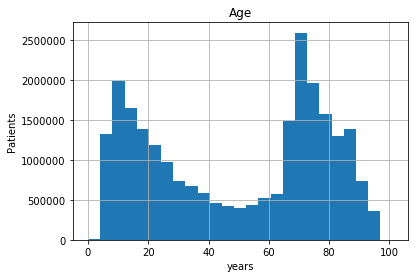

In [65]:
%matplotlib inline

def age_plot(age,
             bins=25, title='Age'):
    plot = age[age >= 0].hist(bins=bins)
    plot.set_title(title)
    plot.set_xlabel('years')
    plot.set_ylabel('Patients')
    plot

age_plot(demo.age);

In [72]:
data.groupby('feature').count()

,patient_num,scalar
feature,,
BENE_ENROLLMT_REF_YR,36750895,36750895
EXTRACT_DT,23865193,23865193


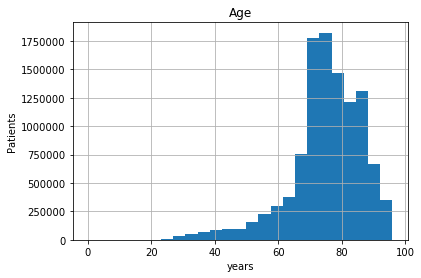

In [68]:
medicare_yr = data[data.feature == 'BENE_ENROLLMT_REF_YR']

age_plot(demo[demo.index.isin(medicare_yr.patient_num)].age)

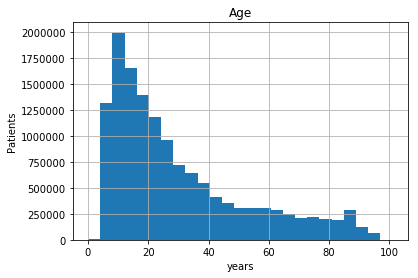

In [77]:
medicaid_yr = data[data.feature == 'EXTRACT_DT          ']

age_plot(demo[demo.index.isin(medicaid_yr.patient_num)].age)